In [1]:
# Importing necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import random_split
from torch.utils.data.dataloader import DataLoader
import torchvision
from torchvision import transforms
from torchvision.datasets import EMNIST
from torchvision.utils import make_grid
from torchvision import models
from tqdm.notebook import tqdm

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
batch_size = 128

In [4]:
train_transforms = transforms.Compose([transforms.Resize(34),
                                      transforms.CenterCrop(32),
                                      transforms.ToTensor()                      
])
test_transforms = transforms.Compose([transforms.Resize(32),
                                     transforms.ToTensor()
])

In [5]:
train_dataset = EMNIST(root = '/', train = True, split = 'letters', transform = train_transforms, download = True)

Extracting /EMNIST/raw/emnist.zip to /EMNIST/raw
Processing byclass


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Processing bymerge
Processing balanced
Processing letters
Processing digits
Processing mnist
Done!


In [6]:
test_dataset = EMNIST(root = '/', train = False, split = 'letters', transform = test_transforms, download = True)

In [7]:
val_size = 5000
train_size = len(train_dataset) - val_size

train_ds, val_ds = random_split(train_dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(119800, 5000)

In [8]:
train_loader = DataLoader(train_ds, batch_size = batch_size, shuffle = True, num_workers = 3, pin_memory = True)
val_loader = DataLoader(val_ds, batch_size = batch_size*2, num_workers = 3, pin_memory = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size*2, num_workers = 4, pin_memory = True)

torch.Size([128, 1, 32, 32])


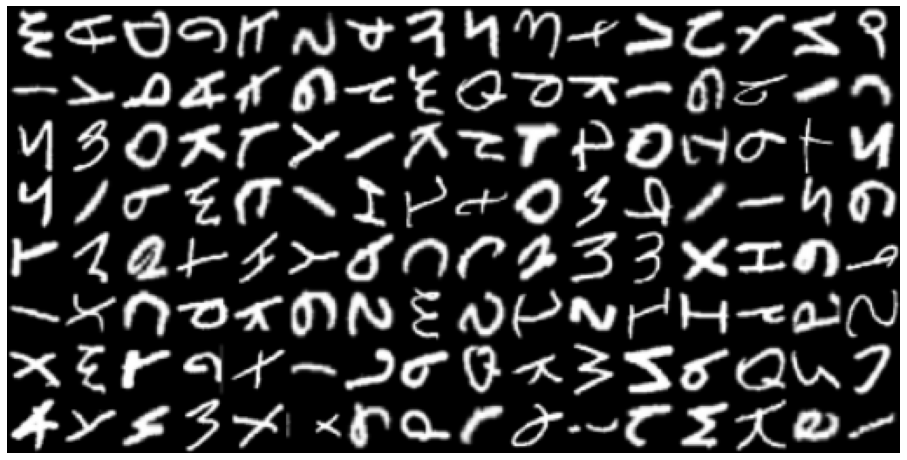

In [9]:
for images, _ in train_loader:
  plt.figure(figsize = (16, 16))
  plt.axis('off')
  for image in images:
    print(images.shape)
    break
  plt.imshow(make_grid(images, nrow = 16, padding = 0).permute(1, 2, 0))
  break

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [11]:
def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking = True)

In [12]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [13]:
train_ddl = DeviceDataLoader(train_loader, device)
val_ddl = DeviceDataLoader(val_loader, device)
test_ddl = DeviceDataLoader(test_loader, device)

In [14]:
def find_accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim =1)
  return ((preds == labels).sum()).item() / len(preds)

In [15]:
class EMNIST(nn.Module):
  def training_batch(self, batch):
    images, labels = batch
    labels -= 1
    outputs = self.forward(images)
    loss = F.cross_entropy(outputs, labels)
    return loss

  def validation_batch(self, batch):
    images, labels = batch
    labels -= 1
    outputs = self.forward(images)
    loss = F.cross_entropy(outputs, labels).item()
    accuracy = find_accuracy(outputs, labels)
    return {'val_loss' : loss, 'val_accuracy' : accuracy}

  def validation_end_epoch(self, outputs):
    epoch_loss = sum([x['val_loss'] for x in outputs]) / len(outputs)
    epoch_accuracy = sum([x['val_accuracy'] for x in outputs]) / len(outputs)
    return {'epoch_loss' : epoch_loss, 'epoch_accuracy' : epoch_accuracy}

In [16]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class EMNIST_ResNet9(EMNIST):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [22]:
model = EMNIST_ResNet9(1, 26)
to_device(model, device)

EMNIST_ResNet9(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inp

In [23]:
@torch.no_grad()
def validate(model, val_ddl):
    model.eval()
    outputs = [model.validation_batch(batch) for batch in val_ddl]
    return model.validation_end_epoch(outputs)

def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

def fit_one_cycle(model, epochs, train_ddl, val_ddl, max_learning_rate, weight_decay=0, grad_clip=None, optimization_func = torch.optim.SGD):
  torch.cuda.empty_cache()
  history=[]
  optimizer = optimization_func(model.parameters(), max_learning_rate, weight_decay=weight_decay)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_learning_rate, epochs=epochs, steps_per_epoch=len(train_ddl))
  for epoch in range(epochs):
    model.train()
    train_losses = []
    learning_rates=[]
    for batch in tqdm(train_ddl):  # insert progress bar
      loss = model.training_batch(batch)
      train_losses.append(loss)
      loss.backward()

      if grad_clip: 
        nn.utils.clip_grad_value_(model.parameters(), grad_clip)

      optimizer.step()
      optimizer.zero_grad()

      learning_rates.append(get_lr(optimizer))
      scheduler.step()

    result = validate(model, val_ddl)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    result['lrs'] = learning_rates
    history.append(result)
    print('Epoch: {}, Last LR: {:.5f}, Train loss: {:.4f}, Validation loss: {:.5f}, Validation accuracy: {:.5f}'.format(epoch, result['lrs'][-1], result['train_loss'], result['epoch_loss'], result['epoch_accuracy']))
  return history

In [24]:
history = [validate(model, val_ddl)]
history

[{'epoch_accuracy': 0.03918887867647059, 'epoch_loss': 3.2595975279808043}]

In [25]:
epochs = 8
max_lr= 3e-3
weight_decay = 1e-4
grad_clip = 0.1
opt_func = torch.optim.Adam

In [26]:
%%time
history += fit_one_cycle(model, epochs, train_ddl, val_ddl, max_learning_rate=max_lr, weight_decay=weight_decay, grad_clip=grad_clip, optimization_func=opt_func)


Epoch: 0, Last LR: 0.00119, Train loss: 0.3173, Validation loss: 0.34816, Validation accuracy: 0.88466



Epoch: 1, Last LR: 0.00281, Train loss: 0.2537, Validation loss: 0.24140, Validation accuracy: 0.92105



Epoch: 2, Last LR: 0.00292, Train loss: 0.2107, Validation loss: 0.22247, Validation accuracy: 0.92857



Epoch: 3, Last LR: 0.00244, Train loss: 0.1836, Validation loss: 0.21119, Validation accuracy: 0.92994



Epoch: 4, Last LR: 0.00167, Train loss: 0.1662, Validation loss: 0.16016, Validation accuracy: 0.94354



Epoch: 5, Last LR: 0.00085, Train loss: 0.1441, Validation loss: 0.13751, Validation accuracy: 0.95179



Epoch: 6, Last LR: 0.00023, Train loss: 0.1085, Validation loss: 0.11699, Validation accuracy: 0.95858



Epoch: 7, Last LR: 0.00000, Train loss: 0.0757, Validation loss: 0.11068, Validation accuracy: 0.96151
CPU times: user 5min 9s, sys: 3min 38s, total: 8min 48s
Wall time: 9min 4s


Text(0.5, 1.0, 'Accuracy vs No. of Epochs')

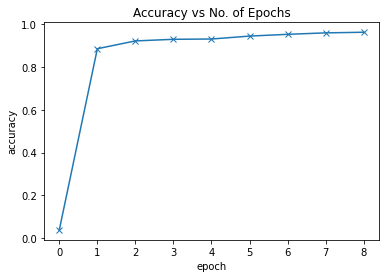

In [27]:
accuracies = [x['epoch_accuracy'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs No. of Epochs')

In [28]:
validate(model, test_ddl)

{'epoch_accuracy': 0.953125, 'epoch_loss': 0.12927927123950567}